In [12]:
import gerrychain
from gerrychain import (
    MarkovChain,
    constraints,
    accept,
    GeographicPartition,
    updaters
)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_seed_part, bipartition_tree, recursive_tree_part
from functools import partial
from tqdm import tqdm
import pandas as pd
import os
import click
import random
from division_aware import *
import matplotlib.pyplot as plt
from utilities import *
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
graph = Graph.from_json("shapes/wisconsin2020_graph_cousub.json")
munis, nodes_by_muni = get_divisions(graph, "COUSUB")
counties, nodes_by_county = get_divisions(graph, "COUNTYFP")

In [7]:
epsilon = 0.02
steps = 500
first_check_division = True
division_aware = True
POP_COL = "TOTPOP19"
division_tuples = [("COUNTYFP", 1), ("COUSUB", 1)]

In [15]:
my_updaters = {"population": updaters.Tally(POP_COL, alias="population")}

In [63]:
def L1(vec):
    return sum(abs(v) for v in vec)

def P1(partition, elections):
    num_dists = len(partition)
    num_R_seats = 0
    for election in elections:
        num_R_seats += partition[election].wins('Rep')
    average_R_vote_share = np.mean([partition[election].percent('Rep') for election in elections])
    average_R_seat_share = num_R_seats / (num_dists * len(elections))
    return abs(average_R_seat_share - average_R_vote_share)

def P2(partition, elections):
    num_dists = len(partition)
    proportionality_vector = []
    for election in elections:
        vote_share = partition[election].percent("Rep")
        seat_share = partition[election].wins("Rep") / num_dists
        proportionality_vector.append(seat_share - vote_share)
    return L1(proportionality_vector)

def D(partition, elections):
    num_dists = len(partition)
    num_R_seats = 0
    for election in elections:
        num_R_seats += partition[election].wins('Rep')
    seat_share = num_R_seats / (num_dists * len(elections))
    return seat_share

In [64]:
def guided_acceptance_factory(elections, acceptance='D'):
    
    def accept_more_P1(partition):
        parent = partition.parent
        child_P1 = P1(partition, elections)
        parent_P1 = P1(parent, elections)
        probability = min([math.exp(1800*(parent_P1 - child_P1)), 1])
        if random.random() < probability:
            return True
        else:
            return False

    def accept_more_P2(partition):
        parent = partition.parent
        child_P2 = P2(partition, elections)
        parent_P2 = P2(parent, elections)
        probability = min([math.exp(180*(parent_P2 - child_P2)), 1])
        if random.random() < probability:
            return True
        else:
            return False
        
    def accept_more_D(partition):
        parent = partition.parent
        child_D = D(partition, elections)
        parent_D = D(parent, elections)
        probability = min([math.exp(1800*(parent_D - child_D)), 1])
        if random.random() < probability:
            return True
        else:
            return False
        
    if acceptance == 'P1':
        return accept_more_P1
    elif acceptance == 'P2':
        return accept_more_P2
    elif acceptance == 'D':
        return accept_more_D

In [66]:
initial_partition = make_partition_from_districtr_csv("WI", graph, "WI1")
ideal_population = sum(initial_partition.population.values()) / len(initial_partition)
if division_aware:
    proposal = partial(recom,
                       pop_col = POP_COL,
                       pop_target = ideal_population,
                       epsilon = epsilon,
                       method = partial(division_bipartition_tree,
                                       division_tuples=division_tuples,
                                       first_check_division = first_check_division),
                       node_repeats = 2)
else:
    proposal = partial(recom,
                       pop_col=POP_COL,
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=2)

elections = states["WI"]["elections"].keys()
acceptance = guided_acceptance_factory(elections, acceptance='D')

chain = MarkovChain(
                    proposal = proposal,
                    constraints = [constraints.within_percent_of_ideal_population(initial_partition, epsilon)],
                    accept = acceptance,
                    initial_state = initial_partition,
                    total_steps = steps)

In [67]:
P1s = []
P2s = []
Ds  = []
for i, part in enumerate(chain.with_progress_bar()):
    P1s.append(P1(part, elections))
    P2s.append(P2(part, elections))
    Ds.append(D(part, elections))

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'D')

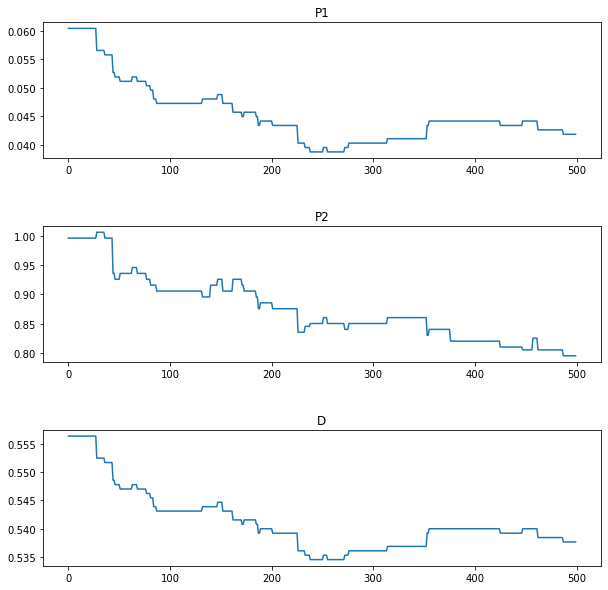

In [68]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
ax[0].plot(P1s)
ax[0].set_title("P1")
ax[1].plot(P2s)
ax[1].set_title("P2")
ax[2].plot(Ds)
ax[2].set_title("D")